In [1]:
# Dicoding Course "Belajar Pengembangan Machine Learning" 3rd Project: Advanced Image Classifier

# Animal Classifier

# Hanif Rachmadani on 16/07/2021.

# Dataset used : https://www.kaggle.com/madisona/translated-animals10

In [2]:
# TF & Data-prepping Libraries Import

import tensorflow as tf
from google.colab import files
import os, shutil

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Dataset Download

files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

!kaggle datasets download -d madisona/translated-animals10

!mkdir translated-animals10
!unzip translated-animals10.zip -d translated-animals10
!ls translated-animals10

Streaming output truncated to the last 5000 lines.
  inflating: translated-animals10/animals10/raw-img/spider/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: translated-animals10/animals10/raw-img/spider/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: translated-animals10/animals10/raw-img/spider/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: translated-animals10/animals10/raw-img/spider/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: translated-animals10/animals10/raw-img/spider/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: translated-animals10/animals10/raw-img/spider/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: translated-animals10/animals10/raw-img/spider/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: translated-animals10/animals10/raw-img/spider/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: translated-animals10/animals10/raw-img/spider/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: translated-animals10/animals10/raw-img/spider/OIP-Md4AMcvjaHciv

In [4]:
# Unused Label Removal

# Note: only 3 label used from a total of 10 to simplify things

base_dir = 'translated-animals10/animals10/raw-img'

animals = os.listdir(base_dir)

class_label = ['dog','spider','chicken']

unused_label = [word for word in animals if word not in class_label]

for word in unused_label : shutil.rmtree(os.path.join(base_dir,word))

os.listdir(base_dir)

['spider', 'dog', 'chicken']

In [13]:
# Check Dataset Size Variations

from PIL import Image

total = 0

for animal in class_label:
  dir = os.path.join(base_dir, animal)
  y = len(os.listdir(dir))
  print(animal+':', y)
  total = total + y
  
  img_name = os.listdir(dir)
  for x in range(4):
    img_path = os.path.join(dir, img_name[x])
    img = Image.open(img_path)
    print('-',img.size)
  print('---------------')

print('\nTotal :', total)

chicken: 3098
- (300, 169)
- (300, 272)
- (300, 300)
- (300, 162)
---------------
dog: 4863
- (182, 300)
- (300, 270)
- (225, 300)
- (300, 200)
---------------
spider: 4821
- (300, 225)
- (300, 225)
- (250, 250)
- (300, 225)
---------------

Total : 12782


In [5]:
# ImageDataGenerator (Data Augmentation) Instantiation

image_generator = ImageDataGenerator(
                    rescale=1./255,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    rotation_range=20,
                    zoom_range=0.2,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest',
                    validation_split=0.2)

# Training Data Generation                

train_generator = image_generator.flow_from_directory(
                  base_dir,
                  target_size=(150,150),
                  batch_size=32,
                  class_mode='categorical',
                  subset='training')

# Validation Data Generation

validation_generator = image_generator.flow_from_directory(
                  base_dir,
                  target_size=(150,150),
                  batch_size=32,
                  class_mode='categorical',
                  subset='validation')

# Update Class Label Order

print(train_generator.class_indices)

class_label = ['chicken','dog','spider']

Found 10227 images belonging to 3 classes.
Found 2555 images belonging to 3 classes.
{'chicken': 0, 'dog': 1, 'spider': 2}


In [9]:
# Model Design

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),  # Input Layer/1st Convolution Layer : 150x150 px Image split into RGB
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),                             # 4 Convolution Layers
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),                                    # 3 Hidden Layer w/ 50%/20% Dropouts on Each Layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')                                    # Output Layer
])

# Model Compilation

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 512)      

In [10]:
# Callback Declaration

acc_target = 0.92   # Set accuracy target

class modelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > acc_target and logs.get('val_accuracy') > acc_target):  
      print("Accuracy Target of " + str(acc_target) + " on Both Training & Validation Data Reached, Stopping Training...")
      self.model.stop_training = True


In [11]:
# Model Training

history = model.fit(
      train_generator,
      batch_size=32,                            # 32 Data per Batch Loading
      steps_per_epoch=300,                      # 100 Batches Used per Epoch for Training
      epochs=100,                               # 100 Maximum Epoch (Arbitratry)
      validation_data=validation_generator,     
      validation_steps=75,                      # 75 Batches Used per Epoch for Validation
      callbacks=[modelCallback()],              # Callback
      verbose='auto')

Epoch 1/100
300/300 [==============================] - 79s 260ms/step - loss: 1.0839 - accuracy: 0.3798 - val_loss: 1.0741 - val_accuracy: 0.4475
Epoch 2/100
300/300 [==============================] - 77s 257ms/step - loss: 1.0803 - accuracy: 0.3873 - val_loss: 1.0758 - val_accuracy: 0.4804
Epoch 3/100
300/300 [==============================] - 76s 254ms/step - loss: 1.0431 - accuracy: 0.4671 - val_loss: 0.9163 - val_accuracy: 0.5821
Epoch 4/100
300/300 [==============================] - 76s 253ms/step - loss: 0.8934 - accuracy: 0.6003 - val_loss: 0.8289 - val_accuracy: 0.6179
Epoch 5/100
300/300 [==============================] - 76s 252ms/step - loss: 0.7882 - accuracy: 0.6431 - val_loss: 0.7878 - val_accuracy: 0.6450
Epoch 6/100
300/300 [==============================] - 76s 255ms/step - loss: 0.7193 - accuracy: 0.6882 - val_loss: 0.6708 - val_accuracy: 0.7125
Epoch 7/100
300/300 [==============================] - 78s 259ms/step - loss: 0.6722 - accuracy: 0.7221 - val_loss: 0.5862 -

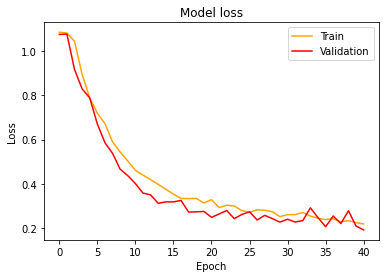

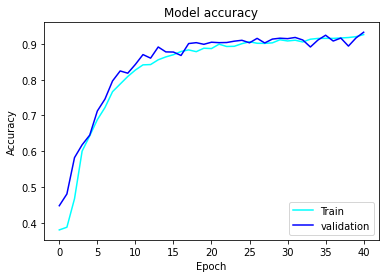

In [12]:
# Pyplot Import

import matplotlib.pyplot as plt

# Loss & Accuracy Graph

plt.plot(history.history['loss'], color="orange")
plt.plot(history.history['val_loss'], color="red")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'], color="cyan")
plt.plot(history.history['val_accuracy'], color="blue")
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','validation'], loc='lower right')
plt.show()

Saving download.jpg to download.jpg
download.jpg
chicken


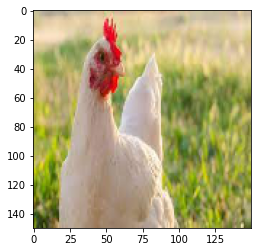

In [15]:
# Libraries Import

import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline

# Upload File(s)

uploaded = files.upload()

# Prediction for Each Files

for fn in uploaded.keys():
 
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  print(fn)
  print(class_label[np.argmax(classes)])

In [35]:
# Convert to TFLite

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpap8oix7a/assets


INFO:tensorflow:Assets written to: /tmp/tmpap8oix7a/assets
